# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd

from collections import Counter, defaultdict

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.externals import joblib

import re
import progressbar

from utils import *

import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 1: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# display more rows and columns
def display_all(df, rows=100):
    """
    Displays 1000 rows and columns
    
    Args:
        df (DataFrame): DataFrame to display
    """
    with pd.option_context("display.max_rows", rows, "display.max_columns", 1000):
        display(df)

In [3]:
# load in the data and use string for column 18 and 19
#azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str',19:'str'})
#customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str',19:'str'})

In [4]:
# save to pickle
#azdias.to_pickle('data/azdias.pkl')
#customers.to_pickle('data/customers.pkl')

In [5]:
# load pickle file
azdias = pd.read_pickle('data/azdias.pkl')
customers = pd.read_pickle('data/customers.pkl')

In [ ]:
print(f'General population (azidas) has {azdias.shape[0]} rows and {azdias.shape[1]} columns')
print(f'Customer population (customers) has {customers.shape[0]} rows and {customers.shape[1]} columns')

Looks like the datasets were loaded correctly. Lets begin this exploration phase with a look at the summary statistics for all continuous variables as well as the first couple of rows.

In [ ]:
azdias.head(2)

In [ ]:
customers.head(2)

One thing that is pretty obvious by just looking at the tables above is that some columns seem to contain a lot of NaN:s. The descriptive summary below shows this as well.

The amount of missing values will increase after converting missing value codes/unknowns to NaN:s

In [ ]:
azdias.describe()

## 1.1 Preprocessing
In this section I'll investigate and handle missing values, re-encode features, some feature engineering as well as feature scaling.

In [6]:
feat_info = pd.read_csv('data/feat_final.csv', sep=',')
feat_info.drop('Unnamed: 0', axis=1, inplace=True)
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


The features information file loaded above contains valuable information about each feature. This file will be used throughout the project to help decide what needs to be done and how to do it.

The feature file is a combination of the old feature file from the unsupervised project in term 1 and the new feature file. To create the feature file used in this project I had to do the following:

- Manually scan through the feature and the attribute file provided for this project and:
	- Assign feature type
	- Assign missing or unknown codes
        - The values for ``'unknown'``, ``'unknown / no main age detectable'``, ``'no transactions known'`` or ``'no transaction known'`` where used to define these codes.
- Check for contradicting information
	- Some features that were found in both the file from term 1 and the one provided for this project have different values for the missing or unknown column.  One example of this is the codes for the feature ``CAMEO_DEUG_2015``. The old feature file states that ``[-1, X]`` should be treated as missing while the new only contains ``[-1]``. For cases like this I decided to go with the values from the file from term 1. The reason for this is simply that this information is corresponding with the values in the dataset better.
- Convert all values in the missing_or_unknown column to abide to the following format:
    - [int] --> [1]
    - [int, int] --> [-1, 0]
    - [int, 'str'] --> [1, 'XX']
    - [] --> []

In [ ]:
azdias['CAMEO_DEUG_2015'].value_counts()

Even though most of the creation of the feature file went smooth some features (57 to be exact) found in the dataset could not be found in any of the provided feature files. This is a problem due to the fact that we have no information about what type of feature these are or what values in those columns that should be treated as missing. I decided to treat all these values as ordinal and assigned an empty array to the missing or unknown column. Another solution would be to just drop all these features.

### 1.1.1 Assess Missing Data

In [ ]:
# missing values per column before converting missing codes
missing_values_unparsed = azdias.isnull().sum()

In [ ]:
# convert missing value codes to NaN
azdias_parsed = convert_missing_codes(azdias, feat_info)

In [ ]:
# missing values per column after converting missing codes
missing_values_parsed = azdias_parsed.isnull().sum()

In [ ]:
missing_before_total = missing_values_unparsed.sum()
missing_after_total = missing_values_parsed.sum()
diff = missing_after_total - missing_before_total

print(f'Number of missing values before converstion: {missing_before_total}')
print(f'Number of missing values after converstion: {missing_after_total}')
print('Increase in missing values: {0:.2f} % '.format(diff / missing_before_total * 100))

In [ ]:
# sorting so feat_info.... is in the same order as other dfs
sorter = missing_values_unparsed.index
sorterIndex = dict(zip(sorter, range(len(sorter))))
feat_info_final_sorted = feat_info.copy()
feat_info_final_sorted['feature_id_rank'] = feat_info_final_sorted['attribute'].map(sorterIndex)
feat_info_final_sorted.sort_values('feature_id_rank', ascending=True, inplace=True)
feat_info_final_sorted = feat_info_final_sorted.drop('feature_id_rank', axis=1)

In [ ]:
df_missing_values = pd.DataFrame(
    {
        'Before': missing_values_unparsed,
        'After': missing_values_parsed,
        'Diff': missing_values_parsed - missing_values_unparsed,
        'Percentage_Missing': missing_values_parsed / azdias.shape[0] * 100,
        'Information_Level': feat_info_final_sorted['information_level'].values
    })

df_missing_values.sort_values(["After", "Diff"], ascending=False).head()

As shown by the table above it's clear that some features have a lot more missing values after converting the missing value codes to NaN:s. Many of the columns that got a substantial increase in NaN's are belonging to ``D19`` (transactional). One thing that they have in common is that they have either "0" or "10" as missing value codes. In the documentation, these values are classified as "no transactions known" and as pointed out earlier I classified this as meaning missing or unknown.

There are probably few columns that are outliers in terms of the proportion of values that are missing. Matplotlib's hist() function will be used visualize the distribution of missing value counts to find these columns.

In [ ]:
fig = plt.figure(figsize=(20,7))
plt.hist(df_missing_values['Percentage_Missing'], bins=np.linspace(0,100,21))
plt.title('Distribution of Missing Values per Feature');
plt.xticks(np.linspace(0,100,21))
plt.xlabel('% Missing Values')
plt.ylabel('Number of Features')
plt.grid()

In [ ]:
less_30 = df_missing_values[df_missing_values['Percentage_Missing'] <= 30]['Percentage_Missing']

fig = plt.figure(figsize=(20,7))
less_30.hist()
plt.title('Distribution of Missing Values per Column <= to 30%');
plt.xlabel('% Missing Values')
plt.ylabel('Number of Features');

In [ ]:
missing_outliers = df_missing_values[df_missing_values['Percentage_Missing'] > 30]
print(f'{missing_outliers.shape[0]} features have more than 30 % missing values.')

Before removing any features lets see if anything interesting can be observed by plotting the amount of missing values per feature grouped by information_level.

In [ ]:
def plot_information_levels(df):
    """
    Plot every feature within each information_level group.
    
    Args:
        df (dataframe) - Dataframe to be used
    """
    sns.set(style='whitegrid')
    sns.set_color_codes('pastel')
    fig = plt.figure(figsize=(15,10))
    information_level = df['Information_Level'].unique()
    for idx, level in enumerate(information_level):
        sns.set()
        fig, ax = plt.subplots()
        sns.set(style="ticks")
        features = df[df['Information_Level'] == level].sort_values(['After'], ascending=False)
        ax = sns.barplot(x=features.index.values, y='After', data=features)
        ax.set(xlabel="Feature", ylabel="# Missing Values", title=level.title())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        fig.set_size_inches(22,7)
            

plot_information_levels(df_missing_values)

Group features by number of missing values and print groups that contain more than one feature.

In [ ]:
# create dict key = # missing values and value = array of features
missing_sorted = missing_values_parsed.sort_values()
missing_groups = dict()
for feat, val in missing_sorted.items():
    if val in missing_groups:
        missing_groups[val].append(feat)
    else:
        missing_groups[val] = [feat]

for val, feat in missing_groups.items():
    if len(feat) > 1:     
        print(f'These features share {val} missing value:\n {feat} \n')

By analyzing the plots and output above I found that features similar features or features that describe similar information but at different scales often have the same amount of missing values. Let's take ``LP_FAMILIE_FEIN`` and ``LP_FAMILIE_GROB`` for example.

In [ ]:
df_missing_values.loc[['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB']]

Both describe the person's family type, but at different scales. Fein translates to fine and Grob to rough. It's also stated that values in ``LP_FAMILIE_FEIN`` map to values in ``LP_FAMILIE_GROB``.

### 1.1.3 Removing Columns

The analysis have shown that the distribution of missing values per feature are skewed to the right meaning most features have zero or a relative small amount of missing values. The majority of the features have less than 30 % missing values.

In [ ]:
features_top_missing = [x for x in missing_outliers.index]
display_all(df_missing_values[df_missing_values.index.isin(features_top_missing)].sort_values('Percentage_Missing', ascending=False))

In [ ]:
old_feat_file = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')

In [ ]:
new_exclusive = np.setdiff1d(features_top_missing, old_feat_file['attribute'])

print(f'Features with more than 30 % missing values originating from old feature file: {len(features_top_missing) - len(new_exclusive)}')
print(f'Features with more than 30 % missing values originating from new feature file: {len(new_exclusive)}')

No clear pattern can be observed for the features with the largest amount of missing values. Many of the features that got a large increase in missing values after the conversion are classified as either household or 125x125_grid. Another observation is that 60 out of the 66 features are from the new feature file. Why this is the case is hard to answer, but it could be because I manually parsed the missing code values (most are either 0 or 10).

Deciding which features to remove from the analysis is difficult. Rather than just using a threshold we should also try to take into account the amount of information we think the features contain. Another important question to ask is why do we have missing values? Is it due to errors, data gathering technique or do we have missing at random, missing completely at random or missing not at random values?

The sparse information regarding each feature in combination with the lack of domain knowledge as well as not knowing the German language makes this almost impossible and for that reason I have decided to use a threshold of 30 %.

In [ ]:
no_missing = df_missing_values[df_missing_values['Percentage_Missing'] == 0]
# skip index
for feat in no_missing[1:].index:
    info = feat_info[feat_info['attribute'] == feat]['information_level'].values
    print(f'{feat} is of information_type: {info}')

All features that have no missing values are of type person or other. ``Other`` is the information_level I added to those features that had no information available. It's possible that I have classified some features wrong which makes it fairly possible that all features that have no missing values are actually of type person.

In [ ]:
# drop features with 30 % or or missing values
azdias_feat_dropped = azdias_parsed.drop(features_top_missing, axis=1)
azdias_feat_dropped.shape

### 1.1.4 Removing Rows

In [ ]:
fig = plt.figure(figsize=(20,7))
azdias_feat_dropped.isnull().sum(axis=1).hist(bins=20)
plt.title('Missing Values per Row');
plt.xlabel('# Features')
plt.ylabel('# Rows');

I'll use a threshold of 30 % which means that rows that have more than 90 features missing will be treated as outliners and dropped. These rows will be placed in a separate dataset.

In [ ]:
azdias_low_missing, azdias_high_missing = split_df(azdias_feat_dropped, 210)

azdias_low_missing.shape, azdias_high_missing.shape

In [ ]:
print(f'Dataset with small amount of missing values per row has {azdias_low_missing.shape[0]} rows')
print(f'Dataset with large amount of missing values per row has {azdias_high_missing.shape[0]} rows')
print(f'New dataset contains {azdias_low_missing.shape[0] / azdias_feat_dropped.shape[0] * 100} % of the original amount of rows')

In [ ]:
columns = ['ZABEOTYP', 'SEMIO_TRADV', 'FINANZ_VORSORGER', 'FINANZTYP', 'ALTERSKATEGORIE_GROB', 'ONLINE_AFFINITAET']

for column in columns:
    compare_columns([azdias_low_missing, azdias_high_missing], column)

Even though the dataset with a high amount of missing values only makes up around 12 % of the total population we should pay close attention to this group. As shown above the distribution for some features are different between the two groups, which suggest that these groups are quite different from each other.

From here on I'll focus the analysis on the group with the smaller amount of missing values.

### 1.1.5 Feature Engineering

Handeling missing values is not the only preprocessing that needs to be done. Since the unsupervised learning algorithms that will be used in the customer segmentation report only work on data that is encoded numerically, all none numerical values must be encoded to numerical. Even though almost all of the values are numerical some of them don't represent numeric values (categories).

The type column in the feature file will be used as guidance in respect to each feature type:
- Interval and numeric features will be left as they are
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [ ]:
feat_info_300 = feat_info[feat_info['attribute'].isin(azdias_low_missing.columns)].copy()
feat_info_300['type'].value_counts()

In [ ]:
obj_features = azdias_low_missing.select_dtypes(include=['object']).columns
for feat in obj_features:
    feat_type = feat_info_300[feat_info_300['attribute'] == feat]['type'].values
    if feat_type not in ['mixed', 'categorical']:
        print(feat)

In [ ]:
feat_info_300.loc[feat_info_300['attribute'] == 'D19_LETZTER_KAUF_BRANCHE', 'type'] = 'categorical'
feat_info_300.loc[feat_info_300['attribute'] == 'EINGEFUEGT_AM', 'type'] = 'mixed'

D19_LETZTER_KAUF_BRANCHE and EINGEFUEGT_AM are both features that are of type object. I've decided to classifiy D19_LETZTER_KAUF_BRANCHE as categorical and EINGEFUEGT_AM as mixed and they will be re-encoded with their corresponding type down below.

In [ ]:
types = get_feature_types(azdias_low_missing, feat_info_300)

In [ ]:
print(f"Remaining categorical features in the dataset:\n {types['categorical']}")

In [ ]:
binary, multiple = categorical_info(azdias_low_missing, types['categorical'])
print('Binary Features:')
print('\n'.join('Column: {} Values: {}'.format(k, v) for k, v in binary.items()))
print('-' * 35)
print('Multi-Level Features:')
print('\n'.join('Column: {} Values: {}'.format(k, v) for k, v in multiple.items()))

In [ ]:
for k,v in multiple.items():
    print(k)

In [ ]:
print(f"Remaining mixed features in the dataset:\n {types['mixed']}")

As stated above the ordinal and interval features will be treated as raw numeric values meaning they will be left alone. With regards to the categorical and mixed features I've decided to do the following:

- ``OST_WEST_KZ`` is the only binary categorical feature that needs to be re-encoded.
- ``WOHNLAGE`` will be treated as categorical and re-encoded with dummy.
- ``CAMEO_INTL_2015`` combines information on two axes: wealth and life stage. Out of this feature two new ordinal features will be created. This will be achieved by splitting the original feature by it's tens- and ones-place.
- ``PRAEGENDE_JUGENDJAHRE`` combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, two new variables will be created to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- ``EINGEFUEGT_AM`` is in date format and will be re-encoded to capture the year.  
- ``PLZ8_BAUMAX`` will be treated as interval (no change)
- ``KBA05_HERSTTEMP`` and ``KBA05_MODTEMP`` will also be treated as interval (no change)
- ``LP_LEBENSPHASE_FEIN`` and ``LP_LEBENSPHASE_GROB`` will be dropped due to being high dimensional and to hard to separate in a good way.
- ``LNR`` is some kind of id/index and will be dropped.

I'll create a clean_data function that will be used to apply the re-enconding above and 

In [ ]:
azdias_cleaned = clean_data(azdias, feat_info)

In [ ]:
azdias_cleaned.to_pickle('data/azdias_cleaned.pkl')

In [ ]:
customers_cleaned = clean_data(customers, feat_info, customer_data=True)

In [ ]:
customers_cleaned.to_pickle('data/customers_cleaned.pkl')

## Part 2: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [7]:
# load pickle files
azdias_cleaned = pd.read_pickle('data/azdias_cleaned.pkl')
customers_cleaned = pd.read_pickle('data/customers_cleaned.pkl')

azdias_cleaned.shape, customers_cleaned.shape

((785318, 468), (140355, 468))

### 2.1 Feature Scaling
Before applying dimensional reduction techniques to the data, feature scaling needs to be done so that the principal component vectors are not influenced by the natural differences in scale for features.

In [8]:
scaler = StandardScaler()

# fit transform
scaled = scaler.fit_transform(azdias_cleaned.astype(float))

azdias_scaled = pd.DataFrame(data=scaled, index=azdias_cleaned.index, columns=azdias_cleaned.columns)
print("original shape:   ", azdias_cleaned.shape)
print("scaled shape:", azdias_scaled.shape)

original shape:    (785318, 468)
scaled shape: (785318, 468)


### 2.2.1 Perform Dimensionality Reduction

With the data scaled, we are now ready to apply dimensionality reduction techniques.

- Sklearn's PCA class will be used to perform principal component analysis on the data, thus finding the vectors of maximal varaiance in the data. To start with all the features will be kept (so there's enough features to see the general trend in variability).
- Both the ratio of variance explained by each component as well as the cumulative variance explained will be plotted.
- Re-evaluate the number of components to keep and then re-fit the transform the data.

In [9]:
# apply PCA
pca = PCA()

# fit transform
azdias_pca = pca.fit_transform(azdias_scaled)

In [10]:
# Investigate the variance accounted for by each principal component.
variance = pca.explained_variance_ratio_

cumsum_variance=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
cumsum_variance

array([ 6.3, 10.3, 14. , 16.2, 18. , 19.6, 21.1, 22.5, 23.7, 24.8, 25.9,
       26.9, 27.8, 28.6, 29.4, 30.1, 30.8, 31.5, 32.2, 32.9, 33.5, 34.1,
       34.7, 35.3, 35.9, 36.5, 37.1, 37.6, 38.1, 38.6, 39.1, 39.6, 40.1,
       40.6, 41.1, 41.6, 42.1, 42.6, 43. , 43.4, 43.8, 44.2, 44.6, 45. ,
       45.4, 45.8, 46.2, 46.6, 47. , 47.4, 47.8, 48.2, 48.6, 49. , 49.4,
       49.8, 50.1, 50.4, 50.7, 51. , 51.3, 51.6, 51.9, 52.2, 52.5, 52.8,
       53.1, 53.4, 53.7, 54. , 54.3, 54.6, 54.9, 55.2, 55.5, 55.8, 56.1,
       56.4, 56.7, 57. , 57.3, 57.6, 57.9, 58.2, 58.5, 58.8, 59.1, 59.4,
       59.7, 59.9, 60.1, 60.3, 60.5, 60.7, 60.9, 61.1, 61.3, 61.5, 61.7,
       61.9, 62.1, 62.3, 62.5, 62.7, 62.9, 63.1, 63.3, 63.5, 63.7, 63.9,
       64.1, 64.3, 64.5, 64.7, 64.9, 65.1, 65.3, 65.5, 65.7, 65.9, 66.1,
       66.3, 66.5, 66.7, 66.9, 67.1, 67.3, 67.5, 67.7, 67.9, 68.1, 68.3,
       68.5, 68.7, 68.9, 69.1, 69.3, 69.5, 69.7, 69.9, 70.1, 70.3, 70.5,
       70.7, 70.9, 71.1, 71.3, 71.5, 71.7, 71.9, 72

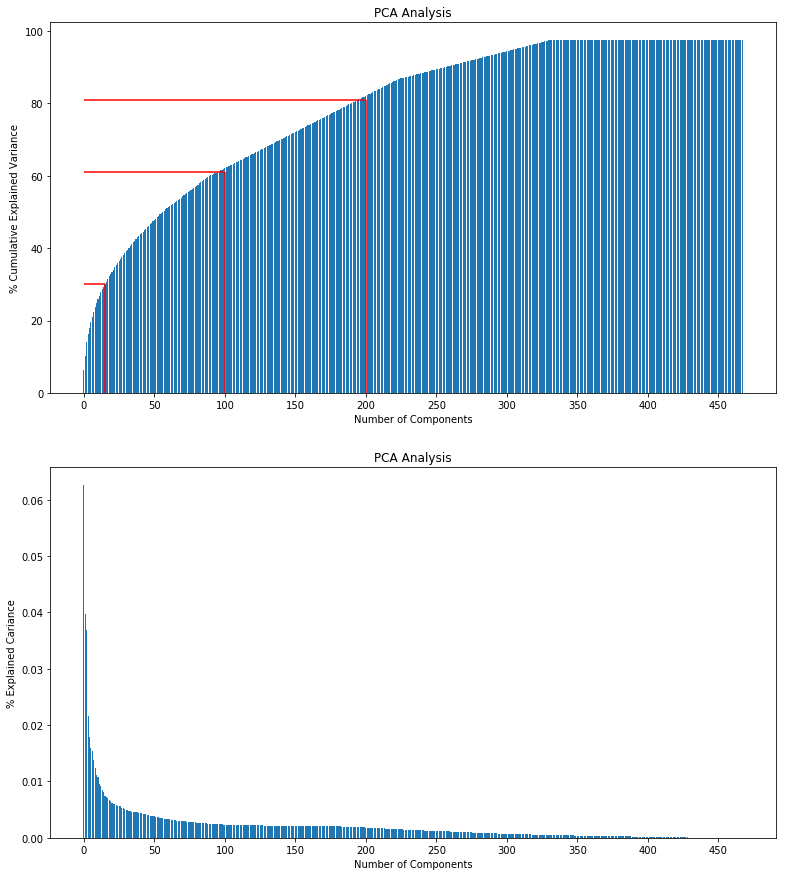

In [11]:
n_components = len(pca.explained_variance_ratio_)
index = np.arange(n_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(13,15))
plt.subplot(2, 1, 1)
plt.bar(index, cumsum_variance)
plt.ylabel('% Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.xticks(np.linspace(0,500, 10, endpoint=False))
plt.title('PCA Analysis')

# 15 components
plt.hlines(y=30, xmin=0, xmax=15, color='red', linestyles='-',zorder=1)
plt.vlines(x=15, ymin=0, ymax=30, color='red', linestyles='-',zorder=2)

# 100 components
plt.hlines(y=61, xmin=0, xmax=100, color='red', linestyles='-',zorder=3)
plt.vlines(x=100, ymin=0, ymax=61, color='red', linestyles='-',zorder=4)

# 200
plt.hlines(y=81, xmin=0, xmax=200, color='red', linestyles='-',zorder=5)
plt.vlines(x=200, ymin=0, ymax=81, color='red', linestyles='-',zorder=6)

plt.subplot(2, 1, 2)
plt.bar(index, vals)
plt.xticks(np.linspace(0,500, 10, endpoint=False))
plt.xlabel('Number of Components')
plt.ylabel('% Explained Cariance')
plt.title('PCA Analysis');

The plots above show that the explained variance plateaus a couple of times. The first and sharpest drop-off is around 15 components. At 15 componenets around 30 % of the total variance is explained. After this we can observe two other, but not as steep drop-offs around 100 and 200 components. At 100 components 61 % of the total variance is explained and at 200 82 %.

With each consecutive component less and less variance is explained which means that after a while the amount of additional explained variance probably is not worth the extra number of components.

With that said 100 components could be considered a good middle point.

In [12]:
n_components = 100
print(f'{n_components} has a cumulative explained variane of: {sum(pca.explained_variance_ratio_[:n_components])}')

100 has a cumulative explained variane of: 0.618311215306494


In [13]:
# re-fit with n components
# apply PCA
pca = PCA(n_components=n_components)

# fit transform
azdias_pca = pca.fit_transform(azdias_scaled)

### 2.2.2 Interpret Principal Components
Now that we have our transformed principal components, it's a good idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

In [14]:
dim1 = interpret_pca(azdias_scaled, pca, 0)
display_all(dim1)

,Explained Variance,PLZ8_ANTG3,KBA13_ANTG3,KBA13_ANTG4,KBA13_BAUMAX,PLZ8_ANTG4,PLZ8_BAUMAX,WEALTH,LP_STATUS_GROB_1.0,HH_EINKOMMEN_SCORE,EWDICHTE,ORTSGR_KLS9,FINANZ_HAUSBAUER,PLZ8_ANTG2,ARBEIT,KBA13_HALTER_30,LP_STATUS_FEIN_1.0,KBA05_ANTG4,KBA13_HALTER_35,CAMEO_DEUG_2015_9,KBA05_ANTG3,STRUKTURTYP,RELAT_AB,ANZ_HAUSHALTE_AKTIV,KONSUMZELLE,ANZ_STATISTISCHE_HAUSHALTE,KBA13_ANTG2,CJT_TYP_2,VK_DISTANZ,LP_STATUS_FEIN_2.0,VK_ZG11,MOVEMENT,KBA13_ALTERHALTER_30,CAMEO_DEUG_2015_8,VK_DHT4A,FINANZ_SPARER,LP_FAMILIE_GROB_1.0,LP_FAMILIE_FEIN_1.0,D19_KONSUMTYP_MAX,FINANZTYP_1,D19_KONSUMTYP_9.0,KBA13_BJ_2000,AKT_DAT_KL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,WOHNLAGE_4.0,CJT_TYP_1,ZABEOTYP_5,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_9C,KBA13_VORB_3,KBA05_ZUL1,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9B,GEBAEUDETYP_3.0,KBA13_KW_0_60,KBA13_ALTERHALTER_45,KBA13_NISSAN,WOHNLAGE_5.0,SEMIO_PFLICHT,KBA13_HALTER_40,RT_KEIN_ANREIZ,KBA13_FAB_SONSTIGE,KBA13_HERST_SONST,KBA13_SEG_KOMPAKTKLASSE,SEMIO_REL,EINGEZOGENAM_HH_JAHR,DECADE,W_KEIT_KIND_HH,KBA05_VORB2,KBA13_CCM_0_1400,GFK_URLAUBERTYP_12.0,KBA13_BJ_1999,KBA05_ALTER1,D19_VERSI_DATUM,REGIOTYP,KBA13_RENAULT,KBA13_HERST_EUROPA,KBA13_HERST_ASIEN,KBA13_MAZDA,VHN,KBA13_SEG_SONSTIGE,VERDICHTUNGSRAUM,SEMIO_RAT,SEMIO_FAM,KBA05_MAXVORB,SEMIO_MAT,KBA05_KW1,KBA13_KMH_180,ALTERSKATEGORIE_FEIN,CAMEO_DEU_2015_8B,ZABEOTYP_6,NATIONALITAET_KZ_2.0,KBA13_SEG_KLEINST,KBA13_HHZ,KBA13_KW_40,KBA13_VORB_2,GEBAEUDETYP_8.0,KKK,KBA13_KMH_0_140,SEMIO_KAEM,WOHNLAGE_3.0,KBA13_CCM_1000,KBA13_HALTER_25,KBA13_CCM_1400,SEMIO_TRADV,PLZ8_HHZ,KBA05_CCM1,CAMEO_DEU_2015_9A,KBA13_KW_50,SEMIO_KULT,SHOPPER_TYP_2.0,CAMEO_DEU_2015_8C,FINANZ_ANLEGER,KBA05_MAXHERST_5.0,KBA13_TOYOTA,KBA05_MAXHERST_4.0,CAMEO_DEUG_2015_7,KBA13_SEG_KLEINWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_FAB_ASIEN,VERS_TYP,KBA05_HERST5,CAMEO_DEU_2015_8D,KBA13_CCM_1200,KBA13_PEUGEOT,CAMEO_DEU_2015_7B,KBA13_KRSSEG_KLEIN,KBA13_SEG_MINIWAGEN,HEALTH_TYP,ANZ_HH_TITEL,FINANZ_UNAUFFAELLIGER,KBA13_KW_60,GFK_URLAUBERTYP_11.0,KBA05_SEG3,SEMIO_SOZ,KBA13_KRSHERST_FORD_OPEL,KBA05_ALTER2,KBA13_SITZE_5,CJT_KATALOGNUTZER,KBA05_CCM2,ZABEOTYP_4,KBA05_HERST4,SEMIO_DOM,NATIONALITAET_KZ_3.0,GFK_URLAUBERTYP_4.0,KBA05_KRSHERST3,KBA13_FIAT,CAMEO_DEU_2015_7C,D19_VERSI_OFFLINE_DATUM,CAMEO_DEU_2015_9E,KBA05_ANTG2,CJT_GESAMTTYP_3.0,DSL_FLAG,KBA13_HALTER_66,SEMIO_KRIT,LP_STATUS_FEIN_3.0,KBA13_CCM_1600,CJT_GESAMTTYP_4.0,FINANZTYP_5,CAMEO_DEU_2015_7D,KBA05_SEG2,CAMEO_DEU_2015_6E,SHOPPER_TYP_1.0,KBA05_KRSKLEIN,KBA13_KMH_140_210,KBA13_FORD,RETOURTYP_BK_S,KBA05_MAXSEG_1.0,KBA13_ALTERHALTER_61,ANREDE_KZ,CJT_GESAMTTYP_6.0,CAMEO_DEU_2015_7A,UMFELD_ALT,ZABEOTYP_3,KBA13_KMH_140,KBA13_KW_70,CAMEO_DEU_2015_6A,KBA05_MAXHERST_3.0,GFK_URLAUBERTYP_8.0,KBA05_HERST3,D19_VERSI_ONLINE_DATUM,CJT_GESAMTTYP_5.0,KBA13_SEG_OBERKLASSE,CAMEO_DEU_2015_5D,KBA13_KW_30,KBA05_MAXSEG_3.0,CAMEO_DEU_2015_6F,KBA13_SITZE_4,CAMEO_DEU_2015_7E,LP_FAMILIE_FEIN_3.0,KBA05_MAXHERST_1.0,LP_FAMILIE_FEIN_4.0,CAMEO_DEU_2015_6D,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV,KBA13_SEG_OBEREMITTELKLASSE,CAMEO_DEU_2015_6C,GEBAEUDETYP_5.0,CAMEO_DEUG_2015_6,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_KONSUMTYP_5.0,FINANZTYP_4,D19_LETZTER_KAUF_BRANCHE_D19_REISEN,D19_LETZTER_KAUF_BRANCHE_D19_KOSMETIK,LP_FAMILIE_GROB_3.0,KBA13_BMW,KBA05_HERSTTEMP,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5E,KBA13_KMH_110,SOHO_KZ,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS,GEBAEUDETYP_6.0,D19_LETZTER_KAUF_BRANCHE_D19_LOTTO,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL,D19_VERSI_ONLINE_QUOTE_12,D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO,D19_TELKO_ONLINE_QUOTE_12,ANZ_TITEL,GEBAEUDETYP_4.0,KBA05_FRAU,LP_FAMILIE_FEIN_9.0,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,D19_LETZTER_KAUF_BRANCHE_D19_RATGEBER,KBA05_MOD3,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK,LP_FAMILIE_FEIN_5.0,D19_LETZTER_KAUF_BRANCHE_D19_SAMMELARTIKEL,KBA13_HERST_FORD_OPEL,KBA05_MAXSEG_2.0,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_GA

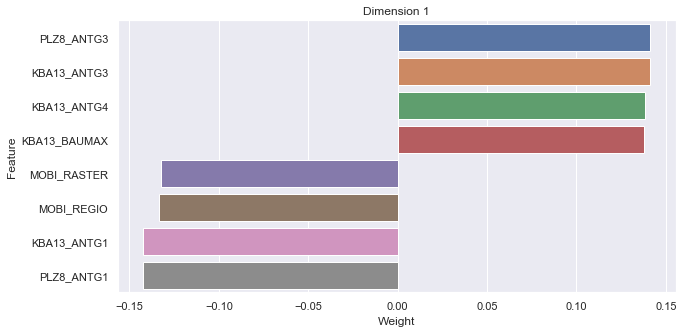

In [15]:
plot_pca(dim1, 1)

In [16]:
dim2 = interpret_pca(azdias_scaled, pca, 1)
display_all(dim2)

,Explained Variance,KBA13_HERST_BMW_BENZ,KBA13_MERCEDES,KBA13_SEG_OBEREMITTELKLASSE,KBA13_BMW,KBA13_SITZE_4,KBA13_SEG_SPORTWAGEN,KBA05_HERST1,KBA13_KMH_211,KBA13_KMH_250,KBA13_KW_121,KBA13_SEG_OBERKLASSE,KBA05_KW3,KBA13_CCM_2501,EWDICHTE,KBA13_CCM_3000,KBA13_KRSHERST_BMW_BENZ,KBA05_MOD1,KBA05_MOTOR,KBA05_CCM4,KBA13_HALTER_65,KBA13_CCM_3001,STRUKTURTYP,OST_WEST_KZ,ORTSGR_KLS9,KBA05_SEG5,KBA05_MAXHERST_1.0,KBA05_MAXSEG_4.0,KBA13_CCM_2500,GREEN_AVANTGARDE,KBA13_ALTERHALTER_61,KBA05_SEG8,KBA05_CCM3,FINANZTYP_5,KBA13_HALTER_66,KBA05_KRSHERST1,KBA13_VORB_0,KONSUMZELLE,KBA13_KMH_251,KBA13_HHZ,KBA05_SEG10,KBA13_SITZE_6,PLZ8_HHZ,LP_STATUS_FEIN_3.0,KBA13_FIAT,KBA13_KRSSEG_OBER,WOHNLAGE_1.0,KBA05_SEG6,KBA13_KW_110,KBA13_KW_120,KBA13_CCM_2000,KBA13_SEG_GELAENDEWAGEN,KBA13_ANTG2,PLZ8_ANTG2,KBA13_KRSZUL_NEU,KBA13_AUDI,KBA05_VORB0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_5.0,CAMEO_DEU_2015_5D,KBA13_SEG_WOHNMOBILE,KBA13_ANTG3,KBA13_SEG_GROSSRAUMVANS,CAMEO_DEUG_2015_1,KBA13_BJ_2008,FINANZ_VORSORGER,VHN,GEBAEUDETYP_3.0,PLZ8_ANTG3,KBA13_ANTG4,PLZ8_ANTG4,KBA05_DIESEL,KBA05_ZUL4,KBA13_BAUMAX,KBA05_KRSOBER,KBA13_HALTER_40,KBA05_MAXBJ,KBA13_SEG_MINIWAGEN,KBA05_MAXAH,KBA13_KMH_210,PLZ8_BAUMAX,RETOURTYP_BK_S,KBA05_ALTER4,KBA13_BJ_2009,WOHNLAGE_2.0,KBA13_ALTERHALTER_45,SEMIO_LUST,RELAT_AB,KBA13_SEG_UTILITIES,KBA05_KRSZUL,CAMEO_DEU_2015_8B,VERDICHTUNGSRAUM,ANZ_HH_TITEL,KBA05_SEG7,CAMEO_DEU_2015_2D,DSL_FLAG,GFK_URLAUBERTYP_3.0,KBA13_HALTER_45,W_KEIT_KIND_HH,KOMBIALTER,SEMIO_DOM,CAMEO_DEU_2015_1E,CAMEO_DEUG_2015_5,CAMEO_DEU_2015_1D,CJT_TYP_4,GFK_URLAUBERTYP_10.0,KBA05_ZUL3,KBA05_ANTG4,KBA13_KW_61_120,ANZ_HAUSHALTE_AKTIV,ALTERSKATEGORIE_GROB,LP_STATUS_FEIN_7.0,KBA13_KRSHERST_AUDI_VW,VERS_TYP,VK_DHT4A,ANZ_STATISTISCHE_HAUSHALTE,D19_SOZIALES,KBA05_HERST2,KBA05_MOD8,KBA13_ANZAHL_PKW,SHOPPER_TYP_3.0,KBA05_MAXSEG_3.0,CAMEO_DEU_2015_1A,D19_VERSI_DATUM,WOHNLAGE_3.0,KBA05_KW2,LP_FAMILIE_GROB_1.0,LP_FAMILIE_FEIN_1.0,RT_SCHNAEPPCHEN,GFK_URLAUBERTYP_4.0,D19_KONSUMTYP_3.0,SEMIO_KAEM,GFK_URLAUBERTYP_8.0,CJT_TYP_5,KBA13_HALTER_35,LP_STATUS_GROB_3.0,LP_STATUS_FEIN_1.0,ZABEOTYP_3,CAMEO_DEU_2015_1C,KBA05_FRAU,SEMIO_KRIT,VK_DISTANZ,KBA05_ANTG2,CJT_TYP_6,KBA13_KW_90,PLZ8_GBZ,ZABEOTYP_1,ANZ_TITEL,KBA13_GBZ,CJT_KATALOGNUTZER,KBA13_SEG_VAN,CAMEO_DEU_2015_7B,FINANZTYP_2,KBA13_HERST_AUDI_VW,KBA05_KRSHERST2,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH,CAMEO_DEUG_2015_2,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,GEBAEUDETYP_8.0,KBA05_MAXHERST_2.0,KBA05_KRSAQUOT,KBA05_SEG9,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_5A,KBA13_BJ_2006,VK_ZG11,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,FINANZ_HAUSBAUER,FINANZ_UNAUFFAELLIGER,SEMIO_ERL,D19_KONSUMTYP_MAX,SEMIO_SOZ,NATIONALITAET_KZ_2.0,CAMEO_DEU_2015_4D,LIFE_STAGE,D19_VERSI_OFFLINE_DATUM,LP_STATUS_FEIN_6.0,ZABEOTYP_6,CAMEO_DEU_2015_5E,KBA13_PEUGEOT,WOHNLAGE_4.0,FINANZ_MINIMALIST,D19_KONSUMTYP_9.0,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_5F,LP_STATUS_GROB_2.0,ZABEOTYP_2,SHOPPER_TYP_1.0,CAMEO_DEUG_2015_7,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_7C,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,D19_KONSUMTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_1.0,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_4E,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST,D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO,D19_LETZTER_KAUF_BRANCHE_D19_NAHRUNGSERGAENZUNG,GEBAEUDETYP_6.0,AKT_DAT_KL,HH_DELTA_FLAG,D19_LETZTER_KAUF_BRANCHE_D19_SAMMELARTIKEL,WOHNDAUER_2008,KBA13_CCM_1800,KBA05_ALTER3,D19_LETZTER_KAUF_BRANCHE_D19_SCHUHE,SEMIO_VERT,D19_VERSI_ONLINE_DATUM,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_GROB_2.0,D19_LETZTER_KAUF_BRANCHE_D19_LEBENSMITTEL,UMFELD_JUNG,GEBAEUDETYP_4.0,D19_LETZTER_KAUF_BRANCHE_D19_REISEN,CAMEO_DEU_2015_2A,KBA13_MOTOR,CAMEO_DEU_2015_3C,CJT_TYP_3,D19_KONSUMTYP_5.0,D19_LETZTER_KAUF_BRANCHE_D19_LOTTO,D19_LETZTER_KAUF_BRANCHE_D19_RATGEBER,ANREDE_KZ,D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV,KBA13_VORB_1,LP_STATUS_GROB_1.0,CAMEO_DEU_2015_9D,CJT_GESAMTTYP_6.0,UNGLEICHENN_FLAG,GEBAEUDETYP_5.0,CAMEO_DEU_2015_6D,SOHO_KZ,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL,FINANZTYP_1,D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_G

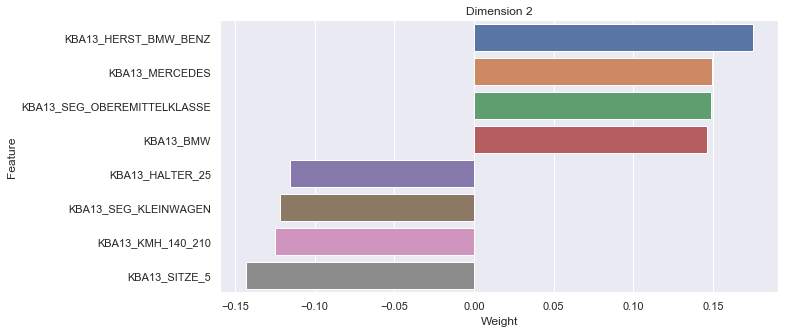

In [17]:
plot_pca(dim2, 2)

In [18]:
dim3 = interpret_pca(azdias_scaled, pca, 2)
display_all(dim3)

,Explained Variance,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,CJT_TYP_5,CJT_TYP_4,CJT_TYP_3,CJT_TYP_6,ZABEOTYP_3,KOMBIALTER,CJT_KATALOGNUTZER,SEMIO_LUST,RETOURTYP_BK_S,SEMIO_ERL,W_KEIT_KIND_HH,FINANZ_MINIMALIST,CJT_GESAMTTYP_2.0,FINANZTYP_2,FINANZTYP_5,VK_DHT4A,FINANZTYP_6,CJT_GESAMTTYP_1.0,WOHNDAUER_2008,NATIONALITAET_KZ_1.0,FINANZ_HAUSBAUER,LP_STATUS_FEIN_1.0,SHOPPER_TYP_3.0,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_KONSUMTYP_9.0,GFK_URLAUBERTYP_4.0,KBA13_HERST_ASIEN,ARBEIT,KBA13_SEG_KOMPAKTKLASSE,GFK_URLAUBERTYP_7.0,KBA05_ALTER4,LP_FAMILIE_GROB_1.0,LP_FAMILIE_FEIN_1.0,KBA13_SITZE_5,D19_KONSUMTYP_MAX,D19_VERSI_DATUM,D19_KONSUMTYP_3.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_FEIN_2.0,KBA05_MAXAH,KBA13_SEG_KLEINWAGEN,KBA13_FAB_ASIEN,CAMEO_DEU_2015_8D,KBA05_VORB0,KBA13_NISSAN,KBA05_SEG3,LIFE_STAGE,KBA13_HALTER_25,KBA13_ANTG3,LP_STATUS_FEIN_3.0,D19_SOZIALES,UMFELD_JUNG,KBA13_SEG_KLEINST,WEALTH,GFK_URLAUBERTYP_5.0,CAMEO_DEU_2015_9E,PLZ8_ANTG3,KBA13_RENAULT,KBA13_ANTG4,KBA13_ALTERHALTER_30,KBA13_MAZDA,GFK_URLAUBERTYP_3.0,PLZ8_ANTG4,RT_SCHNAEPPCHEN,KBA13_HERST_SONST,KBA13_FAB_SONSTIGE,KBA05_CCM1,KBA13_KMH_140_210,CAMEO_DEU_2015_6E,KBA13_BAUMAX,RELAT_AB,GFK_URLAUBERTYP_6.0,CAMEO_DEUG_2015_8,PLZ8_BAUMAX,ANZ_STATISTISCHE_HAUSHALTE,SEMIO_VERT,KBA13_TOYOTA,KBA05_HERST5,D19_VERSI_OFFLINE_DATUM,KBA13_HALTER_30,KBA05_ANTG4,KBA13_KMH_180,KBA13_KW_0_60,SEMIO_KRIT,KBA13_CCM_1400,KBA05_CCM2,LP_STATUS_FEIN_9.0,ANZ_HAUSHALTE_AKTIV,KBA13_HALTER_66,KBA05_MAXHERST_5.0,KBA05_SEG2,KBA05_KW1,CAMEO_DEU_2015_8C,VK_DISTANZ,KBA05_MAXBJ,ZABEOTYP_6,CAMEO_DEUG_2015_6,KBA13_CCM_0_1400,ORTSGR_KLS9,KBA05_ANTG3,KBA13_CCM_1600,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_5.0,EWDICHTE,KBA13_FORD,KBA05_MOD3,KBA13_ALTERHALTER_61,PLZ8_ANTG2,WOHNLAGE_3.0,KBA05_ZUL2,D19_VERSI_ONLINE_DATUM,CAMEO_DEU_2015_7E,LP_STATUS_GROB_4.0,VHA,KBA13_HERST_EUROPA,KBA05_MAXHERST_4.0,VHN,ANZ_HH_TITEL,GFK_URLAUBERTYP_8.0,KBA13_SEG_SONSTIGE,KBA13_KW_60,KBA13_CCM_1200,KBA13_HERST_FORD_OPEL,GEBAEUDETYP_2.0,CAMEO_DEU_2015_6F,HH_EINKOMMEN_SCORE,KBA13_KRSHERST_FORD_OPEL,KBA13_KW_50,CAMEO_DEU_2015_3D,KBA05_MAXSEG_2.0,KBA05_HERST4,KBA13_KRSSEG_KLEIN,KBA13_VORB_0,KBA13_KW_40,KBA13_HALTER_20,KBA13_CCM_1000,D19_LETZTER_KAUF_BRANCHE_D19_SAMMELARTIKEL,KBA13_SEG_MITTELKLASSE,LP_STATUS_FEIN_7.0,KBA13_ANTG2,VERS_TYP,KKK,KBA05_KRSKLEIN,KBA13_PEUGEOT,CAMEO_DEU_2015_7C,STRUKTURTYP,DSL_FLAG,KBA13_KW_80,D19_LETZTER_KAUF_BRANCHE_D19_NAHRUNGSERGAENZUNG,CAMEO_DEU_2015_6D,KBA05_HERST3,KBA13_KW_70,CAMEO_DEU_2015_7D,KBA05_ZUL4,KBA05_KRSZUL,KBA13_OPEL,KBA05_MAXHERST_3.0,KBA05_KRSHERST3,CAMEO_DEU_2015_8A,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,KBA05_ZUL3,D19_LETZTER_KAUF_BRANCHE_D19_GARTEN,VERDICHTUNGSRAUM,KBA13_BJ_2006,FIRMENDICHTE,ANZ_TITEL,KBA13_HALTER_60,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,D19_LETZTER_KAUF_BRANCHE_D19_LEBENSMITTEL,GEBAEUDETYP_1.0,D19_LETZTER_KAUF_BRANCHE_D19_ENERGIE,D19_KONSUMTYP_2.0,CAMEO_DEU_2015_6C,KBA05_MAXSEG_1.0,REGIOTYP,D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH,MOVEMENT,D19_LETZTER_KAUF_BRANCHE_D19_HAUS_DEKO,GEBAEUDETYP_4.0,KBA05_MOD4,D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO,CAMEO_DEUG_2015_7,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,KBA13_BJ_2004,CAMEO_DEU_2015_5F,GEBAEUDETYP_RASTER,GEBAEUDETYP_6.0,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5E,KBA05_FRAU,CAMEO_DEU_2015_1D,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,KBA13_KRSZUL_NEU,WOHNLAGE_2.0,KBA13_BJ_2009,CAMEO_DEUG_2015_9,D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK,SEMIO_KAEM,KBA05_MODTEMP,KBA13_BJ_2008,CAMEO_DEU_2015_6B,KBA13_CCM_1401_2500,WOHNLAGE_1.0,CAMEO_DEU_2015_1C,GEBAEUDETYP_5.0,WOHNLAGE_4.0,KBA05_ALTER3,KBA13_KMH_110,KBA13_HALTER_35,KBA13_KMH_0_140,BALLRAUM,KBA13_CCM_1800,KBA13_VORB_1,CAMEO_DEU_2015_1E,KBA05_SEG4,CAMEO_DEUG_2015_1,CAMEO_DEU_2015_1B,D19_LETZTER_KAUF_BRANCHE_D19_REISEN,CAMEO_DEU_2015_7B,GFK_URLAUBERTYP_10.0,CAMEO_DEU_2015_5D,D19_TELKO_ONLINE_QUOTE_12,CAMEO_DEU_2015_4D,D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG,SOHO_KZ,LP_STATUS_GROB_3.0,CAMEO_DEU_2015_9B,KBA13_KW_30,D19_LETZTER_KAUF_BRANCHE_D19_RATGEBER,CAMEO_DEU_2015_6A,CAMEO_DEU_2015

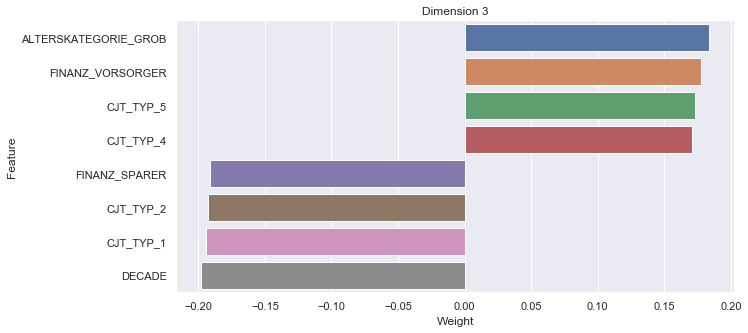

In [19]:
plot_pca(dim3, 3)

## Part 3: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')